<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/combined_approaches/spectral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore

In [174]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [176]:
classes =[]

classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

In [177]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf


In [178]:
!pip install antropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [179]:
from scipy.signal import spectrogram
from scipy.signal import hilbert
import antropy

In [180]:
def instfreq_hil(x, fs):
    """
    Estimate the instantaneous frequency of a signal using the Hilbert transform.
    
    Parameters:
        x (ndarray): The input signal.
        fs (float): The sampling rate of the signal in Hz.
    
    Returns:
        f_inst (ndarray): The estimated instantaneous frequency of the signal.
    """
    # Compute the Hilbert transform of the signal
    analytic_signal = hilbert(x)
    
    # Compute the instantaneous phase of the analytic signal
    phi = np.unwrap(np.angle(analytic_signal))
    
    # Compute the instantaneous frequency of the signal
    f_inst = np.diff(phi) * fs / (2*np.pi)
    f_inst = np.concatenate(([f_inst[0]], f_inst))
    
    return f_inst

In [181]:
def instfreq(x, fs, plot=False):
    """
    Estimate the instantaneous frequency of a signal using the spectrogram method.
    
    Parameters:
        x (ndarray): The input signal.
        fs (float): The sampling rate of the signal in Hz.
    
    Returns:
        f_inst (ndarray): The estimated instantaneous frequency of the signal.
    """
    # Compute the short-time Fourier transform of the signal
    #f, t, Sxx = spectrogram(x, fs=fs, window='hann', nperseg=256, noverlap=128)
    #plt.pcolormesh(t, f, Sxx)

    Sxx, f, t, im = plt.specgram(x, Fs=fs)
    if plot == True:
      plt.show

    # Compute the moments of the spectrogram
    m0 = np.sum(Sxx, axis=0)
    m1 = np.sum(f[:, np.newaxis] * Sxx, axis=0) / m0
    m2 = np.sum((f[:, np.newaxis]**2) * Sxx, axis=0) / m0
    
    # Compute the instantaneous frequency of the signal
    f_inst = (m1 / (2*np.pi)) + (np.sqrt((m2/m0) - (m1/m0)**2) / (2*np.pi))
    
    return np.array(f_inst), t


In [182]:
def pentropy(signal, fs, win_len, step_size = None):
  if step_size == None:
    step_size = win_len

  n_windows = int(np.floor((len(signal) - win_len - step_size) / step_size))
  pentropy = np.zeros(n_windows)
  for i in range(n_windows):
      start_idx = i * step_size
      end_idx = start_idx + win_len
      window = signal[start_idx:end_idx]
      pentropy[i] = antropy.spectral_entropy(window, fs)

  # Print results
  return pentropy

In [183]:
fs = 300.0
sinal = signals[0]
plt.rcParams['figure.figsize']=(8, 5)

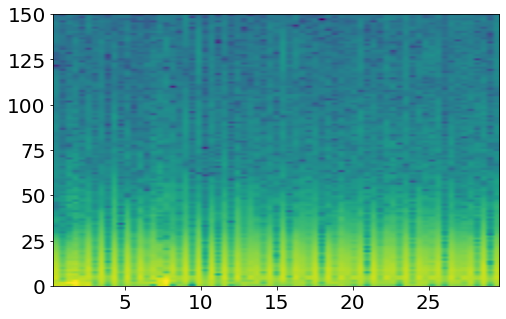

In [184]:
f_inst, t = instfreq(sinal, fs, plot=True)

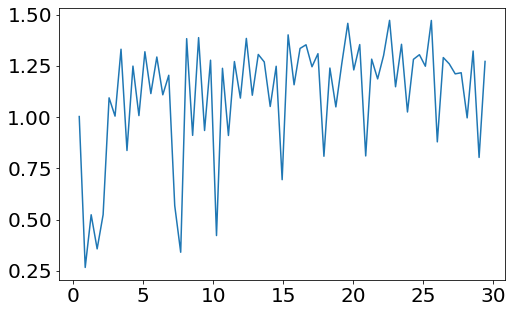

In [185]:
plt.plot(t, f_inst)

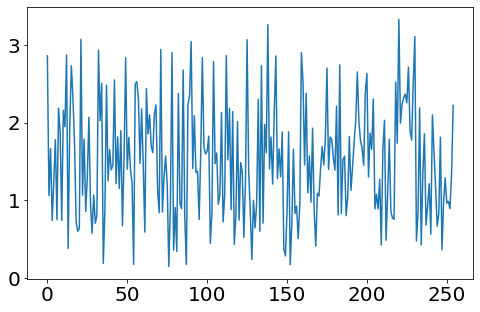

In [186]:
pent = pentropy(sinal, fs, 35)
plt.plot(pent)

In [187]:
# from scipy.signal import hilbert

# analytic_signal = hilbert(d_aux_train["signals"].iloc[0])
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

# plt.plot(instantaneous_frequency)

In [188]:
def norm_sig(signal):

  mn = signal.mean()
  st = signal.std()
  val = (signal - mn)/st

  return val 

/usr/local/lib/python3.9/dist-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
<ipython-input-181-89413b06f5ee>:26: RuntimeWarning: invalid value encountered in sqrt
  f_inst = (m1 / (2*np.pi)) + (np.sqrt((m2/m0) - (m1/m0)**2) / (2*np.pi))


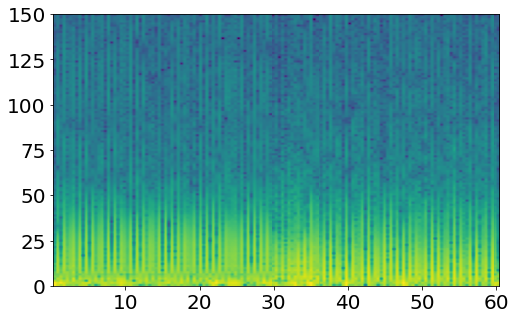

In [189]:
spec_vec = []
for i, x in enumerate(signals):
  f_inst, _ = instfreq(x, fs)
  f_inst = norm_sig(f_inst)

  pent = pentropy(x, fs, 35)
  pent = norm_sig(pent)

  val = list(f_inst) + list(pent)
  spec_vec.append(val)


In [190]:
lsup = len(max(spec_vec, key=len))

In [191]:
lsup

661

In [192]:
def equal_len(signals, lsup):
  cont = -1
  x = []

  for sig in signals:
    cont += 1

    n = math.floor(lsup) - len(sig)

    zeros = np.zeros(int(n))
    x += list(np.concatenate((sig, zeros), axis=None))
    print()

  x = np.array(x)
  x = x.reshape(-1, math.floor(lsup))

  return x  

In [193]:
new_vec = equal_len(spec_vec, lsup)

A saída de streaming foi truncada nas últimas 5000 linhas.















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [194]:
x_train, x_valid, y_train, y_valid = train_test_split(norm_vec, classes, test_size=0.15, shuffle=False)

In [195]:
y_val2 = y_valid
y_trn2 = y_train

In [196]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [197]:
import xgboost as xgb

In [198]:
y_train = pd.DataFrame(y_train)
y_train = pd.get_dummies(y_train)
y_train = np.array(y_train)

In [199]:
xgb_cl = xgb.XGBClassifier()

# kfold = KFold(n_splits=200, random_state=7, shuffle=True)
# results = cross_val_score(xgb_cl, x_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=6)

xgb_cl.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [208]:
y_valid = pd.DataFrame(y_valid)
y_valid = pd.get_dummies(y_valid)
y_valid = np.array(y_valid)

In [209]:
y_pred = xgb_cl.predict(x_valid)

In [210]:
y_pred = pd.DataFrame(y_pred)
y_valid = pd.DataFrame(y_valid)

y_pred.columns = ['A', 'N', 'O', '~']
y_valid.columns = ['A', 'N', 'O', '~']

y_valid = y_valid.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)

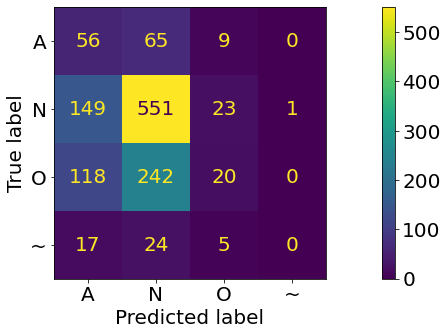

In [211]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_valid, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()

In [212]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_valid, y_pred, target_names = ['A', 'N', 'O', '~']) 
print(relatorio)

              precision    recall  f1-score   support

           A       0.16      0.43      0.24       130
           N       0.62      0.76      0.69       724
           O       0.35      0.05      0.09       380
           ~       0.00      0.00      0.00        46

    accuracy                           0.49      1280
   macro avg       0.29      0.31      0.25      1280
weighted avg       0.47      0.49      0.44      1280



In [213]:
np.save("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/spectral_train", x_train)
np.save("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/spectral_valid", x_valid)

#Teste com LSTM

In [128]:
y_valid = y_val2
y_train = y_trn2

In [129]:
y_valid = pd.get_dummies(y_valid)
y_train = pd.get_dummies(y_train)

In [134]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)

x_train = x_train.reshape(x_train.shape[0] ,-1, x_train.shape[1]) 
x_valid = x_valid.reshape(x_valid.shape[0] ,-1, x_valid.shape[1]) 

In [135]:
x_train.shape

(7248, 661, 1)

In [136]:
inp_shape = int(np.floor(lsup))

In [137]:
classificador_1 = Sequential()

classificador_1.add(LSTM(units=100, return_sequences = True, input_shape=(inp_shape, 1)))

classificador_1.add(Flatten())

classificador_1.add(Dense(32, activation='relu'))
classificador_1.add(Dropout(0.25))
# classificador_1.add(Dense(64, activation='relu'))
# classificador_1.add(Dropout(0.25))
# classificador_1.add(Dense(8, activation='relu'))
# classificador_1.add(Dropout(0.25))

classificador_1.add(Dense(4, activation='softmax'))

classificador_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.015), metrics=["accuracy"])

es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=20)

checkpoint = ModelCheckpoint('_pesos_spectralstm.hdf5', monitor="val_accuracy", verbose=1, 
                                  save_best_only=True, mode='max') 

history_1 = classificador_1.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
                                epochs=150, callbacks=[checkpoint], verbose=1, use_multiprocessing=True, workers=8)

Epoch 1/150
227/227 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2674
Epoch 1: val_accuracy improved from -inf to 0.10156, saving model to _pesos_spectralstm.hdf5
227/227 [==============================] - 136s 586ms/step - loss: nan - accuracy: 0.2674 - val_loss: nan - val_accuracy: 0.1016
Epoch 2/150
227/227 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0866
Epoch 2: val_accuracy did not improve from 0.10156
227/227 [==============================] - 135s 594ms/step - loss: nan - accuracy: 0.0866 - val_loss: nan - val_accuracy: 0.1016
Epoch 3/150
227/227 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0866
Epoch 3: val_accuracy did not improve from 0.10156
227/227 [==============================] - 138s 607ms/step - loss: nan - accuracy: 0.0866 - val_loss: nan - val_accuracy: 0.1016
Epoch 4/150
 82/227 [=========>....................] - ETA: 1:21 - loss: nan - accuracy: 0.0850

KeyboardInterrupt: ignored

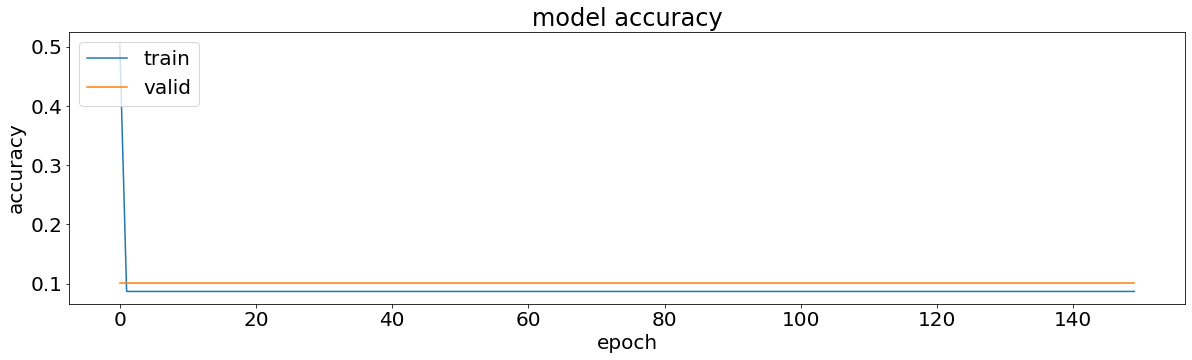

In [106]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [107]:
str(type(classificador_1.layers[0])) == "<class 'keras.layers.rnn.lstm.LSTM'>"

True

In [108]:
model_weights_1 =[]
for i in classificador_1.layers:
  model_weights_1.append(i.get_weights())

In [109]:
model_1 = Sequential()

model_1.add(LSTM(units=128, return_sequences = True,
                       dropout=0.22, recurrent_dropout=0.44, input_shape=(1, inp_shape)
                       ))

model_1.add(LSTM(units=128, return_sequences = True, dropout=0.35, recurrent_dropout=0.36))

model_1.add(Flatten())

model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.25))

In [110]:
count = 0
for i in model_1.layers:
  i.set_weights(model_weights_1[count])
  count += 1

In [111]:
from keras import backend as K

In [112]:
output = K.function([model_1.layers[0].input], [model_1.layers[-1].output])

In [113]:
x_out = output(x_train)

In [114]:
x_out_val = output(x_valid)

In [115]:
x_out = np.array(x_out)
x_out_val = np.array(x_out_val)

In [116]:
x_out = x_out.reshape(x_out.shape[1], x_out.shape[2])
x_out_val = x_out_val.reshape(x_out_val.shape[1], x_out_val.shape[2])

In [117]:
xgb_cl = xgb.XGBClassifier()

# kfold = KFold(n_splits=200, random_state=7, shuffle=True)
# results = cross_val_score(xgb_cl, x_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=6)

xgb_cl.fit(x_out, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [118]:
y_pred = xgb_cl.predict(x_out_val)

In [119]:
y_pred = pd.DataFrame(y_pred)
y_valid = pd.DataFrame(y_valid)

y_pred.columns = ['A', 'N', 'O', '~']
y_valid.columns = ['A', 'N', 'O', '~']

y_valid = y_valid.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)

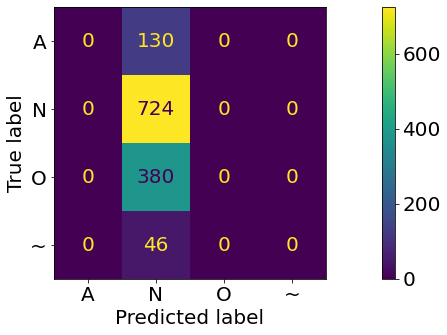

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_valid, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()

In [121]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_valid, y_pred, target_names = ['A', 'N', 'O', '~']) 
print(relatorio)

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       130
           N       0.57      1.00      0.72       724
           O       0.00      0.00      0.00       380
           ~       0.00      0.00      0.00        46

    accuracy                           0.57      1280
   macro avg       0.14      0.25      0.18      1280
weighted avg       0.32      0.57      0.41      1280



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
